# Kapitel 4: Aufbereitung textueller Daten für Statistik und maschinelles Lernen

## Setup
Es werden die Verzeichnisse festgelegt. Wenn Sie mit Google Colab arbeiten: Die erforderlichen Dateien werden kopiert und die erforderlichen Bibliotheken installiert.

## Hinweise
Es werden die Verzeichnisse festgelegt. Wenn Sie mit Google Colab arbeiten: Die erforderlichen Dateien werden kopiert und die erforderlichen Bibliotheken installiert.

Zum Installieren der Sprachpakete: python -m spacy download en_core_web_sm und python -m spacy download en_core_web_lg

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch04/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Python-Einstellungen laden

Allgemeine Importe, Standardwerte für die Formatierung in Matplotlib, Pandas usw.

In [2]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# um die Ausgabe aller Anweisungen und nicht nur der letzten zu drucken
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# sonst wird der Text zwischen den $-Zeichen als Formel interpretiert und kursiv gedruckt
pd.set_option('display.html.use_mathjax', False)

# Pfad zum Importieren von Paketen
sys.path.append(BASE_DIR + '/packages')

# Einführung in den Datensatz: Reddit Self Posts


## Laden der Daten in Pandas


In [3]:
import pandas as pd

posts_file = "rspct.tsv.gz"
posts_file = f"{BASE_DIR}/data/reddit-selfposts/rspct_autos.tsv.gz" ### real location
posts_df = pd.read_csv(posts_file, sep='\t')

subred_file = "subreddit_info.csv.gz"
subred_file = f"{BASE_DIR}/data/reddit-selfposts/subreddit_info.csv.gz" ### real location
subred_df = pd.read_csv(subred_file).set_index(['subreddit'])

df = posts_df.join(subred_df, on='subreddit')
len(df) ###

20000

# 1. Blueprint: Standardisierung von Attributnamen


In [4]:
print(df.columns)

Index(['id', 'subreddit', 'title', 'selftext', 'category_1', 'category_2',
       'category_3', 'in_data', 'reason_for_exclusion'],
      dtype='object')


In [5]:
column_mapping = {
    'id': 'id',
    'subreddit': 'subreddit',
    'title': 'title',
    'selftext': 'text',
    'category_1': 'category',
    'category_2': 'subcategory',  
    'category_3': None, # keien Daten
    'in_data': None, # wird nicht benötigt
    'reason_for_exclusion': None # wird nicht benötigt
}

# restliche Spalten definieren
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]

# diese Spalten auswählen und umbenennen
df = df[columns].rename(columns=column_mapping)

In [6]:
df = df[df['category'] == 'autos']

In [7]:
len(df)

20000

In [8]:
pd.options.display.max_colwidth = None ###
df.sample(1, random_state=7).T
pd.options.display.max_colwidth = 200 ###

,14356
id,7jc2k4
subreddit,volt
title,Dashcam for 2017 volt
text,Hello.<lb>I'm looking into getting a dashcam. <lb>Does anyone have any recommendations? <lb><lb>I'm generally looking for a rechargeable one so that I don't have to route wires down to the cigarette lighter. <lb>Unless there are instructions on how to wire it properly without wires showing. <lb><lb><lb>Thanks!
category,autos
subcategory,chevrolet


## Speichern und Laden eines Data Frames

In [9]:
df.to_pickle("reddit_dataframe.pkl")

In [10]:
import sqlite3

db_name = "reddit-selfposts.db"
con = sqlite3.connect(db_name)
df.to_sql("posts", con, index=False, if_exists="replace")
con.close()

20000

In [11]:
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts", con)
con.close()

In [12]:
len(df)

20000

# Bereinigung von Textdaten


In [13]:
text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>"""

In [14]:
print(text)


After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>


# 2. Blueprint: Erkennen von Rauschen mit regulären Ausdrücken


In [15]:
import re

RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

print(impurity(text))

0.09009009009009009


In [16]:
pd.options.display.max_colwidth = 100 ###
# Hinzufügen einer neuen Spalte zum Data Frame
df['impurity'] = df['text'].progress_apply(impurity, min_len=10)

# die 3 besten Records holen
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3) ###
pd.options.display.max_colwidth = 200 

  0%|          | 0/20000 [00:00<?, ?it/s]

,text,impurity
19682,Looking at buying a 335i with 39k miles and 11 months left on the CPO warranty. I asked the deal...,0.21
12357,I'm looking to lease an a4 premium plus automatic with the nav package.<lb><lb>Vehicle Price:<ta...,0.17
2730,Breakdown below:<lb><lb>Elantra GT<lb><lb>2.0L 4-cylinder<lb><lb>6-speed Manual Transmission<lb>...,0.14


In [17]:
from blueprints.exploration import count_words
count_words(df, column='text', preprocess=lambda t: re.findall(r'<[\w/]*>', t))

  0%|          | 0/20000 [00:00<?, ?it/s]

,freq
token,
<lb>,100729
<tab>,642


# 3. Blueprint: Rauschunterdrückung mit regulären Ausdrücken


In [18]:
import html

def clean(text):
    # html-Escapes wie &amp; in characters umwandeln
    text = html.unescape(text) 
    # Tags wie <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # Markdown-URLs wie [text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # Text oder Code in Klammern wie [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # eigenständige Sequenzen, wie z.B &# aber nicht #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # eigenständige Folgen von Bindestrichen wie --- oder ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # Abfolgen von Leerzeichen
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [19]:
clean_text = clean(text)
print(clean_text)
print("Impurity:", impurity(clean_text))

After viewing the PINKIEPOOL Trailer it got me thinking about the best match ups. Here's my take: Deadpool Captain America
Impurity: 0.0


In [20]:
df['clean_text'] = df['text'].progress_map(clean)
df['impurity']   = df['clean_text'].apply(impurity, min_len=20)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [21]:
df[['clean_text', 'impurity']].sort_values(by='impurity', ascending=False) \
                              .head(3)

,clean_text,impurity
14058,"Mustang 2018, 2019, or 2020? Must Haves!! 1. Have a Credit score of 780\+ for the best low interest rates! 2. Join a Credit Union to finance the vehicle! 3. Or Find a Lender to finance the vehicle...",0.03
18934,"At the dealership, they offered an option for foot-well illumination, but I cannot find any reference to this online. Has anyone gotten it? How does it look? Anyone have pictures. Not sure if this...",0.03
16505,"I am looking at four Caymans, all are in a similar price range. The major differences are the miles, the years, and one isn’t a S. https://www.cargurus.com/Cars/inventorylisting/viewDetailsFilterV...",0.02


# 4. Blueprint: Zeichennormalisierung mit Textacy


In [22]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."

In [23]:
import textacy
import textacy.preprocessing as tprep

if textacy.__version__ < '0.11':
    def normalize(text):
        text = tprep.normalize_hyphenated_words(text)
        text = tprep.normalize_quotation_marks(text)
        text = tprep.normalize_unicode(text)
        text = tprep.remove_accents(text)
        return text

else:
    # angepasst an Textacy 0.11
    def normalize(text):
        text = tprep.normalize.hyphenated_words(text)
        text = tprep.normalize.quotation_marks(text)
        text = tprep.normalize.unicode(text)
        text = tprep.remove.accents(text)
        return text

In [24]:
print(normalize(text))

The cafe "Saint-Raphael" is located on Cote d'Azur.


# 5. Blueprint: Musterbasierte Datenmaskierung mit textacy


In [25]:
from textacy.preprocessing.resources import RE_URL

count_words(df, column='clean_text', preprocess=RE_URL.findall).head(3)

  0%|          | 0/20000 [00:00<?, ?it/s]

,freq
token,
www.getlowered.com,3
http://www.ecolamautomotive.com/#!2/kv7fq,2
https://www.reddit.com/r/Jeep/comments/4ux232/just_ordered_an_android_head_unit_joying_jeep/,2


In [26]:
if textacy.__version__ < '0.11':
    replace_urls = textacy.preprocessing.replace_urls
else:
    replace_urls = textacy.preprocessing.replace.urls

text = "Check out https://spacy.io/usage/spacy-101"

# Verwendung der Standardsubstitution _URL_
print(replace_urls(text))

Check out _URL_


In [27]:
df['clean_text'] = df['clean_text'].progress_map(replace_urls)
df['clean_text'] = df['clean_text'].progress_map(normalize)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [28]:
df.rename(columns={'text': 'raw_text', 'clean_text': 'text'}, inplace=True)
df.drop(columns=['impurity'], inplace=True)

con = sqlite3.connect(db_name)
df.to_sql("posts_cleaned", con, index=False, if_exists="replace")
con.close()

20000

# Tokenisierung


In [29]:
text = """
2019-08-10 23:32: @pete/@louis - I don't have a well-designed 
solution for today's problem. The code of module AC68 should be -1. 
Have to think a bit... #goodnight ;-) 😩😬"""

# 6. Blueprint: Tokenisierung mit regulären Ausdrücken


In [30]:
tokens = re.findall(r'\w\w+', text)
print(*tokens, sep='|')

2019|08|10|23|32|pete|louis|don|have|well|designed|solution|for|today|problem|The|code|of|module|AC68|should|be|Have|to|think|bit|goodnight


In [31]:
RE_TOKEN = re.compile(r"""
               ( [#]?[@\w'’\.\-\:]*\w     # words, hash tags and email adresses
               | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
               | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
               )
               """, re.VERBOSE)

def tokenize(text):
    return RE_TOKEN.findall(text)

tokens = tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


# 7. Blueprint: Tokenisierung mit NLTK


In [32]:
import nltk

nltk.download('punkt') ###
tokens = nltk.tokenize.word_tokenize(text)
print(*tokens, sep='|')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kleme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

2019-08-10|23:32|:|@|pete/|@|louis|-|I|do|n't|have|a|well-designed|solution|for|today|'s|problem|.|The|code|of|module|AC68|should|be|-1|.|Have|to|think|a|bit|...|#|goodnight|;|-|)|😩😬


In [33]:
# Regex Tokenizer
tokenizer = nltk.tokenize.RegexpTokenizer(RE_TOKEN.pattern, flags=re.VERBOSE)
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


In [34]:
# Tweet Tokenizer
tokenizer = nltk.tokenize.TweetTokenizer()
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-|10|23:32|:|@pete|/|@louis|-|I|don't|have|a|well-designed|solution|for|today's|problem|.|The|code|of|module|AC68|should|be|-|1|.|Have|to|think|a|bit|...|#goodnight|;-)|😩|😬


In [35]:
# Toktok Tokenizer
tokenizer = nltk.tokenize.ToktokTokenizer()
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-10|23|:|32|:|@pete/@louis|-|I|don|'|t|have|a|well-designed|solution|for|today|'|s|problem.|The|code|of|module|AC68|should|be|-1.|Have|to|think|a|bit|...|#goodnight|;|-|)|😩😬


# Linguistische Verarbeitung mit spaCy


## Eine Pipeline instanziieren

In [36]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [37]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x217b73f2100>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x217b1714460>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x217b17143a0>)]

In [38]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

## Verarbeitung von Text

In [39]:
nlp = spacy.load("en_core_web_sm")
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [40]:
for token in doc:
    print(token, end="|")

My|best|friend|Ryan|Peters|likes|fancy|adventure|games|.|

In [41]:
def display_nlp(doc, include_punct=False):
    """Generate data frame for visualization of spaCy tokens."""
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i,  'text': t.text, 'lemma_': t.lemma_, 
                   'is_stop': t.is_stop, 'is_alpha': t.is_alpha,
                   'pos_': t.pos_, 'dep_': t.dep_, 
                   'ent_type_': t.ent_type_, 'ent_iob_': t.ent_iob_}
            rows.append(row)
    
    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df

In [42]:
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_
0,My,-PRON-,True,True,DET,poss,,O
1,best,good,False,True,ADJ,amod,,O
2,friend,friend,False,True,NOUN,nsubj,,O
3,Ryan,Ryan,False,True,PROPN,compound,PERSON,B
4,Peters,Peters,False,True,PROPN,appos,PERSON,I
5,likes,like,False,True,VERB,ROOT,,O
6,fancy,fancy,False,True,ADJ,amod,,O
7,adventure,adventure,False,True,NOUN,compound,,O
8,games,game,False,True,NOUN,dobj,,O


# 8. Blueprint: Tokenisierung anpassen


In [43]:
text = "@Pete: choose low-carb #food #eat-smart. _url_ ;-) 😋👍"
nlp = spacy.load('en_core_web_sm') ###
doc = nlp(text)

for token in doc:
    print(token, end="|")

@Pete|:|choose|low|-|carb|#|food|#|eat|-|smart|.|_|url|_|;-)|😋|👍|

In [44]:
import re ###
import spacy ###
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, \
                       compile_infix_regex, compile_suffix_regex

def custom_tokenizer(nlp):
    
    # Standardmuster verwenden, außer denen, die von re.search gefunden werden
    prefixes = [pattern for pattern in nlp.Defaults.prefixes 
                if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes
                if pattern not in ['_']]
    infixes  = [pattern for pattern in nlp.Defaults.infixes
                if not re.search(pattern, 'xx-xx')]

    return Tokenizer(vocab          = nlp.vocab, 
                     rules          = nlp.Defaults.tokenizer_exceptions,
                     prefix_search  = compile_prefix_regex(prefixes).search,
                     suffix_search  = compile_suffix_regex(suffixes).search,
                     infix_finditer = compile_infix_regex(infixes).finditer,
                     token_match    = nlp.Defaults.token_match)

nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = custom_tokenizer(nlp)

doc = nlp(text)
for token in doc:
    print(token, end="|")

@Pete|:|choose|low-carb|#food|#eat-smart|.|_url_|;-)|😋|👍|

# 9. Blueprint: Arbeiten mit Stopp-Wörtern


In [45]:
nlp = spacy.load('en_core_web_sm') ###
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)

non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Dear, Ryan, need, sit, talk, Regards, Pete]


In [46]:
nlp = spacy.load('en_core_web_sm')
nlp.vocab['down'].is_stop = False
nlp.vocab['Dear'].is_stop = True
nlp.vocab['Regards'].is_stop = True

**Hinweis: Modifizierung von Stoppwörtern mit einer Unterklasse**

Die Modifikation des Stoppwortes durch Änderung des Vokabulars ist seit spaCy 3.0 veraltet. Stattdessen empfiehlt es sich, eine Unterklasse der jeweiligen Sprache zu erstellen, etwa so:

In [47]:
# Unterklassenansatz zur Änderung von Stoppwortlisten
# empfohlen ab spaCy Version 3.0
from spacy.lang.en import English

excluded_stop_words = {'down'}
included_stop_words = {'dear', 'regards'}

class CustomEnglishDefaults(English.Defaults):
    stop_words = English.Defaults.stop_words.copy()
    stop_words -= excluded_stop_words
    stop_words |= included_stop_words
    
class CustomEnglish(English):
    Defaults = CustomEnglishDefaults

nlp = CustomEnglish()

text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp.make_doc(text) # nur tokenisieren
    
tokens_wo_stop = [token for token in doc ]
for token in doc:
    if not token.is_stop and not token.is_punct:
        print(token, end='|')

Ryan|need|sit|down|talk|Pete|

In [48]:
# nlp auf Original zurücksetzen
nlp = spacy.load('en_core_web_sm')

# 10. Blueprint: Extraktion von Lemmata auf Basis von Part-of-Speech (= Wortarten)


In [49]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

print(*[t.lemma_ for t in doc], sep='|')

-PRON-|good|friend|Ryan|Peters|like|fancy|adventure|game|.


In [50]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)

[friend, Ryan, Peters, adventure, games]


In [51]:
import textacy

tokens = textacy.extract.words(doc, 
            filter_stops = True,           # default True, no stopwords
            filter_punct = True,           # default True, no punctuation
            filter_nums = True,            # default False, no numbers
            include_pos = ['ADJ', 'NOUN'], # default None = include all
            exclude_pos = None,            # default None = exclude none
            min_freq = 1)                  # minimum frequency of words

print(*[t for t in tokens], sep='|')

best|friend|fancy|adventure|games


In [52]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

lemmas = extract_lemmas(doc, include_pos=['ADJ', 'NOUN'])
print(*lemmas, sep='|')

good|friend|fancy|adventure|game


# 11. Blueprint: Nomenphrasen extrahieren


In [53]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

patterns = ["POS:ADJ POS:NOUN:+"]
spans = textacy.extract.matches(doc, patterns=patterns)
print(*[s.lemma_ for s in spans], sep='|')

good friend|fancy adventure|fancy adventure game


In [54]:
print(*doc.noun_chunks, sep='|')

My best friend|Ryan Peters|fancy adventure games


In [55]:
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")
    spans = textacy.extract.matches(doc, patterns=patterns)
    return [sep.join([t.lemma_ for t in s]) for s in spans]

print(*extract_noun_phrases(doc, ['ADJ', 'NOUN']), sep='|')

good_friend|fancy_adventure|fancy_adventure_game|adventure_game


# 12. Blueprint: Benannte Entitäten extrahieren


In [56]:
text = "James O'Neill, chairman of World Cargo Inc, lives in San Francisco."
doc = nlp(text)

for ent in doc.ents:
    print(f"({ent.text}, {ent.label_})", end=" ")

(James O'Neill, PERSON) (World Cargo Inc, ORG) (San Francisco, GPE) 

In [57]:
from spacy import displacy

displacy.render(doc, style='ent', jupyter=True)

In [58]:
def extract_entities(doc, include_types=None, sep='_'):

    ents = textacy.extract.entities(doc, 
             include_types=include_types, 
             exclude_types=None, 
             drop_determiners=True, 
             min_freq=1)
    
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]

In [59]:
print(extract_entities(doc, ['PERSON', 'GPE']))

["James_O'Neill/PERSON", 'San_Francisco/GPE']


# Merkmalsextraktion in einem großen Datensatz


# 13. Blueprint: Eine Funktion für alle Fälle


In [60]:
def extract_nlp(doc):
    return {
    'lemmas'          : extract_lemmas(doc, 
                                     exclude_pos = ['PART', 'PUNCT', 
                                        'DET', 'PRON', 'SYM', 'SPACE'],
                                     filter_stops = False),
    'adjs_verbs'      : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
    'nouns'           : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
    'noun_phrases'    : extract_noun_phrases(doc, ['NOUN']),
    'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
    'entities'        : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

In [61]:
nlp = spacy.load('en_core_web_sm')

In [62]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['good', 'friend', 'Ryan', 'Peters', 'like', 'fancy', 'adventure', 'game']
adjs_verbs: ['good', 'like', 'fancy']
nouns: ['friend', 'Ryan', 'Peters', 'adventure', 'game']
noun_phrases: ['adventure_game']
adj_noun_phrases: ['good_friend', 'fancy_adventure', 'fancy_adventure_game']
entities: ['Ryan_Peters/PERSON']


In [63]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'adjs_verbs', 'nouns', 'noun_phrases', 'adj_noun_phrases', 'entities']


# 14. Blueprint: Anwendung von spaCy auf einen großen Datensatz


In [64]:
import sqlite3 ###

db_name = "reddit-selfposts.db"
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts_cleaned", con)
con.close()

df['text'] = df['title'] + ': ' + df['text']

In [65]:
for col in nlp_columns:
    df[col] = None

In [66]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

No GPU found, working on CPU.


In [67]:
nlp = spacy.load('en_core_web_sm', disable=[])
nlp.tokenizer = custom_tokenizer(nlp) # optional

In [68]:
# der vollständige Datensatz dauert lange
# für eine schnellere Verarbeitung verwenden Sie ein Beispiel wie dieses
df = df.sample(500)

In [69]:
batch_size = 50 ###
batches = math.ceil(len(df) / batch_size) ###

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

  0%|          | 0/10 [00:00<?, ?it/s]

In [70]:
df[['text', 'lemmas', 'nouns', 'noun_phrases', 'entities']].sample(5)

,text,lemmas,nouns,noun_phrases,entities
13352,"People with highway commutes, do you actually get 50 mile range?: I've never actually gotten to 50 miles of range in the 3 weeks I've had my Volt, it's always closer to 40 miles. I know driving ha...","[People, with, highway, commute, do, actually, get, 50, mile, range, have, never, actually, get, to, 50, mile, of, range, in, 3, week, have, have, volt, be, always, close, to, 40, mile, know, driv...","[People, highway, commute, mile, range, mile, range, week, volt, mile, driving, habit, baby, car, mile, range, indicator, mile, driving, habit, range, mind, commute, mile, charging, station, apart...","[highway_commute, mile_range, driving_habit, range_indicator, driving_habit, charging_station, speed_limit]","[~20_mile/PERSON, CT/GPE]"
13760,"Noob to wrx, a few basic questions: Ok, I'm new to res's but not new to modding jdm. So a few basic questions if I may impose on my new sub I fellows. 1, stock boost ? ('02 bug eye) 2 how HJ can i...","[Noob, to, wrx, few, basic, question, ok, be, new, to, res, but, new, to, modde, jdm, so, few, basic, question, if, may, impose, on, new, sub, fellow, 1, stock, boost, 02, bug, eye, 2, how, HJ, ca...","[Noob, wrx, question, res, jdm, question, sub, stock, boost, bug, eye, HJ, boost, elec, boost, control, ECU, hissy, fit, sti, red, inlet, manifold, turbo, upgrade, vf35, software, basic, thing, si...","[stock_boost, bug_eye, turbo_upgrade, basic_thing, size_cam, stock_displacement, stock_turbo]","[Noob/PERSON, jdm/PERSON, ECU/LOC, cam/ORG]"
17128,"Control Arm Set?: Been having some bad DW in my wrangler unlimited 08 4d. Have changed out track bar, drag link, tie rod, steering stabilizer. So I'm thinking culprit could be bad control arms. I ...","[Control, Arm, Set, be, have, bad, dw, in, wrangler, unlimited, 08, 4d, have, change, out, track, bar, drag, link, tie, rod, steer, stabilizer, so, be, think, culprit, could, be, bad, control, arm...","[Control, Arm, Set, dw, wrangler, 4d, track, bar, drag, link, rod, stabilizer, culprit, control, arm, jeep, site, control, arm, thank, guy]","[track_bar, drag_link, control_arm, control_arm, thank_guy]",[jeep/ORG]
286,What way do the heated mirror wires go in? (Or where to find it in the WIS): So I planned on replacing my wing mirrors (plastic) with painted ones. I also took out the mirror glass. I figured the ...,"[way, do, heated, mirror, wire, go, in, or, where, find, in, WIS, so, plan, on, replace, wing, mirror, plastic, with, paint, one, also, take, out, mirror, glass, figure, wire, should, stay, somewh...","[way, mirror, wire, WIS, wing, mirror, plastic, one, mirror, glass, wire, position, wis, my2000]","[mirror_wire, wing_mirror, mirror_glass]",[]
3982,"2010 911 PDK: Recently whenever (but not always) when I wash the car or gets wet (rain), out of the blue, as I am driving, the message ""Transmission temp too high"" comes on, car won't engage in ge...","[2010, 911, PDK, recently, whenever, but, always, when, wash, car, or, get, wet, rain, out, of, blue, as, be, drive, message, transmission, temp, too, high, come, on, car, will, engage, in, gear, ...","[PDK, car, rain, blue, message, transmission, temp, car, gear, car, sec, message, car, suggestion]",[transmission_temp],[sec/ORG]


  0%|          | 0/500 [00:00<?, ?it/s]

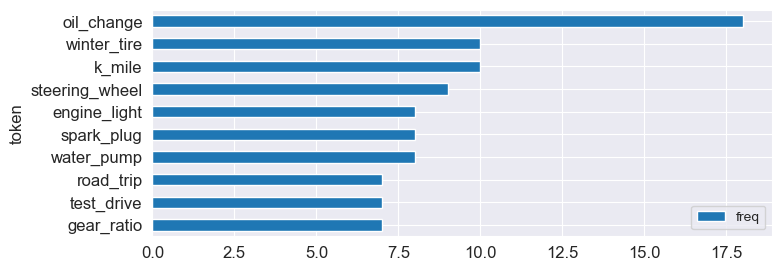

In [71]:
count_words(df, 'noun_phrases').head(10).plot(kind='barh', figsize=(8,3)).invert_yaxis()

## Persisting the Result


In [72]:
df[nlp_columns] = df[nlp_columns].applymap(lambda items: ' '.join(items))

con = sqlite3.connect(db_name) 
df.to_sql("posts_nlp", con, index=False, if_exists="replace")
con.close()

500